# Imports

In [1]:
import sys

stdout = sys.stdout

import htsexperimentation as htsx
import tsaugmentation as tsag
import properscoring as ps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', 100)

sys.stdout = stdout
sns.set()
plt.rcParams.update({'font.size': 22})

# Parameters

In [2]:
datasets=['prison', 'tourism', 'm5', 'police']
algorithms=[
            "gpf",
            "mint",
            "deepar",
            "standard_gp_lin",
            "standard_gp_pie",
            "standard_gp_zer",
            "ets_bu",
            "arima_bu"
        ]

# Loading data
dataset = 'prison'
data = tsag.preprocessing.PreprocessDatasets(dataset).apply_preprocess()
true = data['predict']['data'].reshape((data['predict']['s'], data['predict']['n'])).T

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


# Calculation of CRPS - example for a single series

### GPF

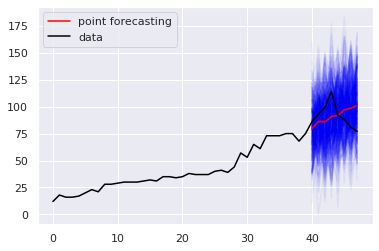

In [3]:
e = htsx.compute_results.get_output(dataset, 'gpf', 'jitter')
series = 9
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['samples']['bottom'][-data['h']:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [4]:
ps.crps_ensemble(true[-data['h']:, series], e['predictions']['samples']['bottom'][-data['h']:, series, :]).mean()

8.944075789904412

### MinT

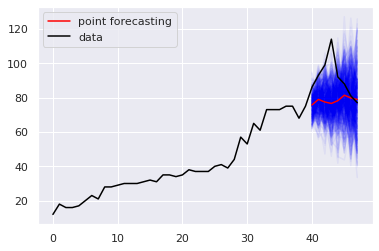

In [5]:
e = htsx.compute_results.get_output(dataset, 'mint', 'jitter')
series = 9
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['samples']['bottom'][-data['h']:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')

plt.legend();

In [6]:
ps.crps_ensemble(true[-data['h']:, series], e['predictions']['samples']['bottom'][-data['h']:, series, :]).mean()

10.336113343621802

### DeepAR

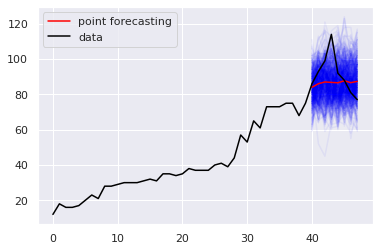

In [7]:
e = htsx.compute_results.get_output(dataset, 'deepar', 'jitter')
series = 9
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['samples']['bottom'][-data['h']:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [8]:
ps.crps_ensemble(true[-data['h']:, series], e['predictions']['samples']['bottom'][-data['h']:, series, :]).mean()

6.313351000000001

# Calculation of MASE for each algorithm

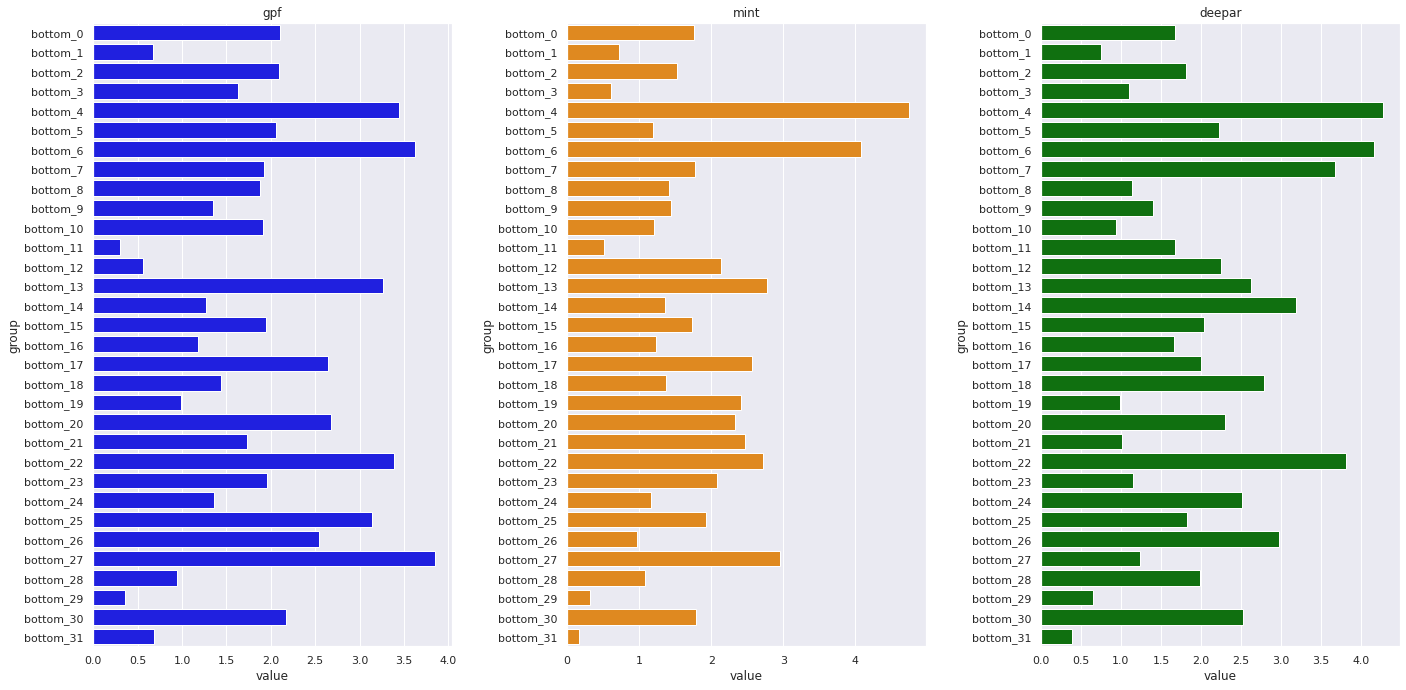

In [9]:
htsx.visualization.plot_compare_err_metric('mase', 'prison', figsize=(20, 10))

# Calculating aggregate results for all algorithms

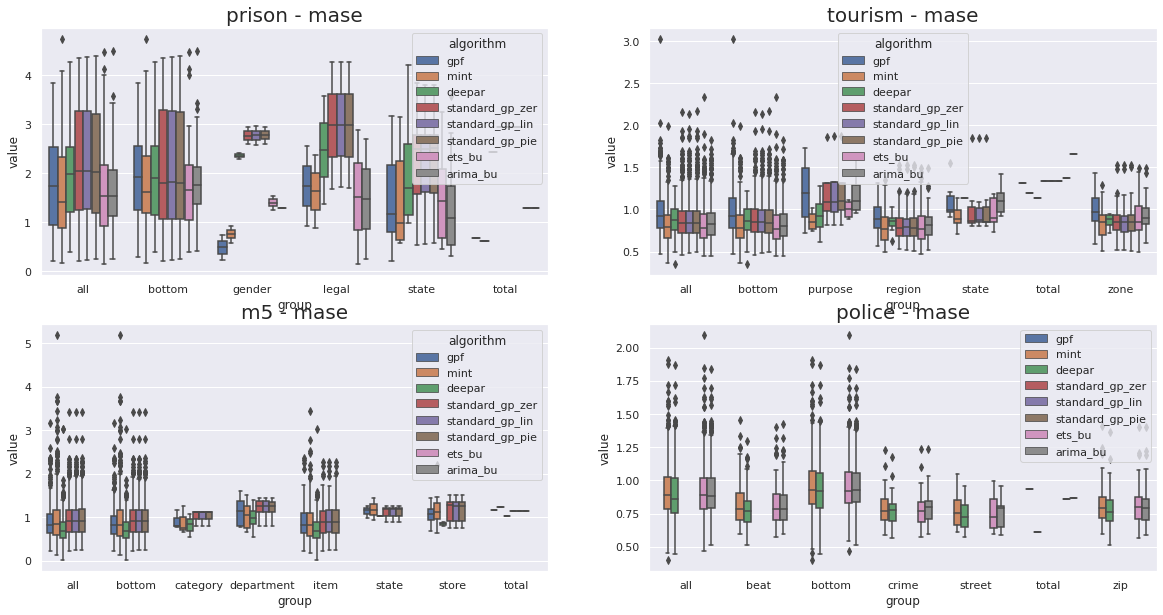

In [14]:
df_orig_list = htsx.compute_results.calculate_agg_results_all_datasets(datasets, 
                                                                       algorithms, 
                                                                       'mase')
htsx.visualization.boxplot_error(df_orig_list, 'mase', datasets, figsize=(20, 10))

In [51]:
def print_res(dataset, df_orig_list):
    dataset_idx = datasets.index(dataset)
    df = df_orig_list[dataset_idx]
    df = df.sort_values(by=['algorithm', 'group'])[['algorithm', 'group', 'value']]
    df = df.groupby(['algorithm', 'group']).mean()['value'].reset_index()
    return df

In [52]:
print_res('prison', df_orig_list)

,algorithm,group,value
0,gpf,all,1.737600
1,gpf,bottom,1.909086
2,gpf,gender,0.489625
3,gpf,legal,1.741250
4,gpf,state,1.493875
5,gpf,total,0.688500
6,mint,all,1.643800
7,mint,bottom,1.766406
8,mint,gender,0.757000
9,mint,legal,1.633000


In [53]:
print_res('tourism', df_orig_list)

,algorithm,group,value
0,gpf,all,0.971761
1,gpf,bottom,0.980411
2,gpf,purpose,1.210000
3,gpf,region,0.903697
4,gpf,state,1.098857
5,gpf,total,1.309000
6,gpf,zone,0.985222
7,mint,all,0.819375
8,mint,bottom,0.820579
9,mint,purpose,0.865000


In [59]:
print_res('m5', df_orig_list)

,algorithm,group,value
0,gpf,all,0.879010
1,gpf,bottom,0.869153
2,gpf,category,0.911833
3,gpf,department,1.135500
4,gpf,item,0.882863
5,gpf,state,1.136333
6,gpf,store,1.067300
7,gpf,total,1.155000
8,mint,all,0.941974
9,mint,bottom,0.947420


In [55]:
print_res('police', df_orig_list)

,algorithm,group,value
0,gpf,all,NaN
1,gpf,beat,NaN
2,gpf,bottom,NaN
3,gpf,crime,NaN
4,gpf,street,NaN
5,gpf,total,NaN
6,gpf,zip,NaN
7,mint,all,0.921135
8,mint,beat,0.825304
9,mint,bottom,0.958348


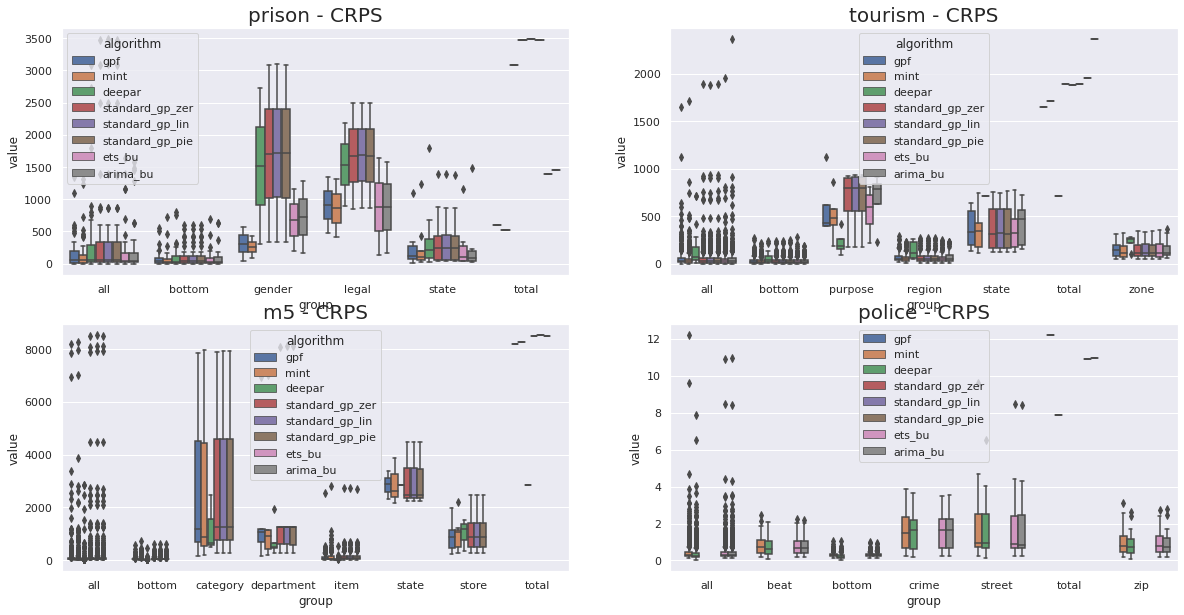

In [11]:
df_orig_list = htsx.compute_results.calculate_agg_results_all_datasets(datasets, 
                                                                       algorithms, 
                                                                       'CRPS')
htsx.visualization.boxplot_error(df_orig_list, 'CRPS', datasets)